# Importing Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict


from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

# Loading data

In [2]:
from hitters_data import *

# Pre processing the data.

In [3]:
# Deleting NA values.
df = df.dropna()

# Creating dummy variables for object type variables.
dummies = pd.get_dummies(df[['League', 'Division','NewLeague']])

# Extracting the response column.
y = df[['Salary']]

# dropping the response and object type variables columns.
X_numerical = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
list_numerical = X_numerical.columns

# Combining the newly created dummy columns with the data.
X = pd.concat([X_numerical, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
feature_names = X.columns

# Splitting the data into test and train.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)
scaler = StandardScaler().fit(X_train[list_numerical]) 
X_train[list_numerical] = scaler.transform(X_train[list_numerical])
X_test[list_numerical] = scaler.transform(X_test[list_numerical])
df_train = y_train.join(X_train)
df_test = y_test.join(X_test)

# Creating contiguous arrays

In [4]:
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

# Defining hyperparameters

In [5]:
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "warm_start":True,
    "oob_score":True,
    "random_state": 42,
}

# Fitting Model

In [6]:
reg =RandomForestRegressor(**params)

reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=4, min_samples_split=5, n_estimators=500,
                      oob_score=True, random_state=42, warm_start=True)

# Making predictions

In [7]:
y_pred = reg.predict(X_test)


# Calculating MSE

In [8]:
mean_squared_error(y_test, y_pred, squared=False)

296.37036964432764

# Implementing feature importance 

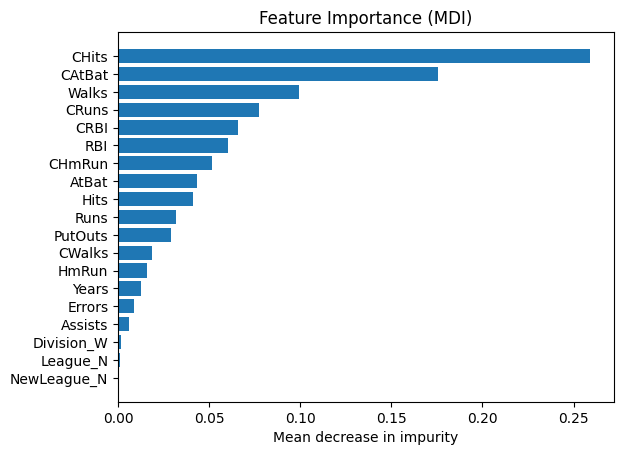

In [9]:
# obtain feature importance
feature_importance = reg.feature_importances_

# sort features according to importance
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0])

# plot feature importances
plt.barh(pos, feature_importance[sorted_idx], align="center")

plt.yticks(pos, np.array(feature_names)[sorted_idx])
plt.title("Feature Importance (MDI)")
plt.xlabel("Mean decrease in impurity");


# Permutation feature importance

In [10]:
result = permutation_importance(
    reg, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

tree_importances = pd.Series(result.importances_mean, index=feature_names)

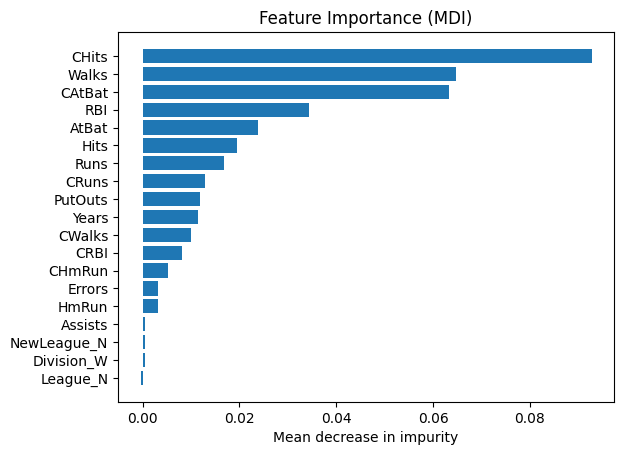

In [11]:
# sort features according to importance
sorted_idx = np.argsort(tree_importances)
pos = np.arange(sorted_idx.shape[0])

# plot feature importances
plt.barh(pos, tree_importances[sorted_idx], align="center")

plt.yticks(pos, np.array(feature_names)[sorted_idx])
plt.title("Feature Importance (MDI)")
plt.xlabel("Mean decrease in impurity");

# Box plot of Permutation feature importance

Text(0.5, 1.0, 'Permutation Importance (test set)')

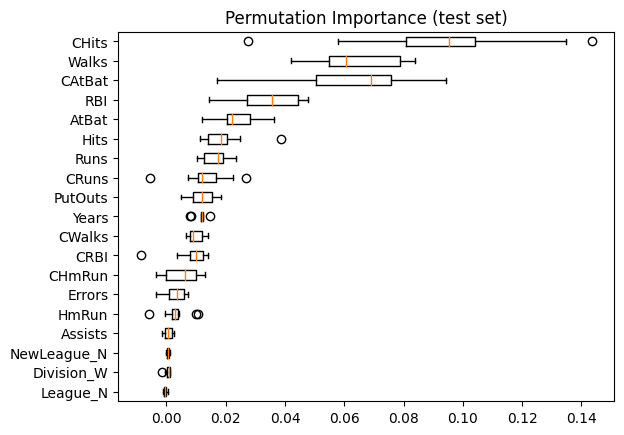

In [12]:
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names)[sorted_idx],
)

plt.title("Permutation Importance (test set)")

In [13]:
df.head()


,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


# Classification Random forest.
Above we created a random forest regression model over the salary column. Now suppose we want to create a classification random forest model for whether or not a player is in top 50% or bottom 50% of salaries. 

To do that we first need to find the 50th percentile of the salary column.

In [14]:
a = df['Salary'].quantile(.5)
a


425.0

Next we create a for loop that will assing the value 1 if the salary of a player is more than the 50th percentile and 0 if the salary is less than the 50th percentile and store this values in a new column called "Salary > 50%".

In [15]:
result = []
for value in df['Salary']:
    if value > a:
        result.append(1)
    else:
        result.append(0)
df['Salary > 50%'] = result
df

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,...,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague,Salary > 50%
1,315,81,7,24,38,39,14,3449,835,69,...,414,375,N,W,632,43,10,475.0,N,1
2,479,130,18,66,72,76,3,1624,457,63,...,266,263,A,W,880,82,14,480.0,A,1
3,496,141,20,65,78,37,11,5628,1575,225,...,838,354,N,E,200,11,3,500.0,N,1
4,321,87,10,39,42,30,2,396,101,12,...,46,33,N,E,805,40,4,91.5,N,0
5,594,169,4,74,51,35,11,4408,1133,19,...,336,194,A,W,282,421,25,750.0,A,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,497,127,7,65,48,37,5,2703,806,32,...,311,138,N,E,325,9,3,700.0,N,1
318,492,136,5,76,50,94,12,5511,1511,39,...,451,875,A,E,313,381,20,875.0,A,1
319,475,126,3,61,43,52,6,1700,433,7,...,93,146,A,W,37,113,7,385.0,A,0
320,573,144,9,85,60,78,8,3198,857,97,...,420,332,A,E,1314,131,12,960.0,A,1


# Splitting the data.

In [16]:
df.dtypes

AtBat             int64
Hits              int64
HmRun             int64
Runs              int64
RBI               int64
Walks             int64
Years             int64
CAtBat            int64
CHits             int64
CHmRun            int64
CRuns             int64
CRBI              int64
CWalks            int64
League           object
Division         object
PutOuts           int64
Assists           int64
Errors            int64
Salary          float64
NewLeague        object
Salary > 50%      int64
dtype: object

In [17]:
# Deleting NA values.
df = df.dropna()

# Creating dummy variables for object type variables.
dummies = pd.get_dummies(df[['League', 'Division','NewLeague']])

# Extracting the response column.
y = df[['Salary > 50%']]

# dropping the response and object type variables columns.
X_numerical = df.drop(['Salary > 50%', 'Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
list_numerical = X_numerical.columns

# Combining the newly created dummy columns with the data.
X = pd.concat([X_numerical, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
feature_names = X.columns

# Splitting the data into test and train.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)
scaler = StandardScaler().fit(X_train[list_numerical]) 
X_train[list_numerical] = scaler.transform(X_train[list_numerical])
X_test[list_numerical] = scaler.transform(X_test[list_numerical])
df_train = y_train.join(X_train)
df_test = y_test.join(X_test)

y_train = np.ravel(y_train)
y_test = np.ravel(y_test)




In [18]:
X.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_N,Division_W,NewLeague_N
1,315.0,81.0,7.0,24.0,38.0,39.0,14.0,3449.0,835.0,69.0,321.0,414.0,375.0,632.0,43.0,10.0,1,1,1
2,479.0,130.0,18.0,66.0,72.0,76.0,3.0,1624.0,457.0,63.0,224.0,266.0,263.0,880.0,82.0,14.0,0,1,0
3,496.0,141.0,20.0,65.0,78.0,37.0,11.0,5628.0,1575.0,225.0,828.0,838.0,354.0,200.0,11.0,3.0,1,0,1
4,321.0,87.0,10.0,39.0,42.0,30.0,2.0,396.0,101.0,12.0,48.0,46.0,33.0,805.0,40.0,4.0,1,0,1
5,594.0,169.0,4.0,74.0,51.0,35.0,11.0,4408.0,1133.0,19.0,501.0,336.0,194.0,282.0,421.0,25.0,0,1,0


# Fitting a RF classification model.

In [19]:
rfc=RandomForestClassifier(random_state=42)

# Defining hyperparameters

In [20]:
param_grid = { 
    'n_estimators': [100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

# Implementing cross validation.

In [21]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 500]})

# Getting the best hyperparameters.

In [22]:
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 7,
 'max_features': 'auto',
 'n_estimators': 200}

# Fitting a RF classifier with the best hyperparams.

In [23]:
rfc1 = RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 200, max_depth=7, criterion='gini')

# Calculating train accuracy.

In [24]:
rfc1.fit(X_train, y_train)
pred=rfc1.predict(X_train)
print("Accuracy for Random Forest on CV data: ", accuracy_score(y_train,pred))

Accuracy for Random Forest on CV data:  1.0


# Making predictions and calculating test accuracy.

In [25]:
pred=rfc1.predict(X_test)
print("Accuracy for Random Forest on CV data: ", accuracy_score(y_test,pred))

Accuracy for Random Forest on CV data:  0.8987341772151899


# Feature Importance.

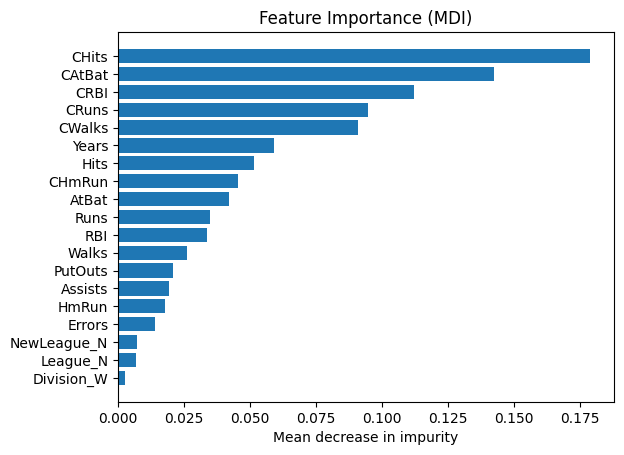

In [26]:
# obtain feature importance
feature_importance = rfc1.feature_importances_

# sort features according to importance
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0])

# plot feature importances
plt.barh(pos, feature_importance[sorted_idx], align="center")

plt.yticks(pos, np.array(feature_names)[sorted_idx])
plt.title("Feature Importance (MDI)")
plt.xlabel("Mean decrease in impurity");


# Permutation feature importance.

In [27]:
result = permutation_importance(
    rfc1, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

tree_importances = pd.Series(result.importances_mean, index=feature_names)

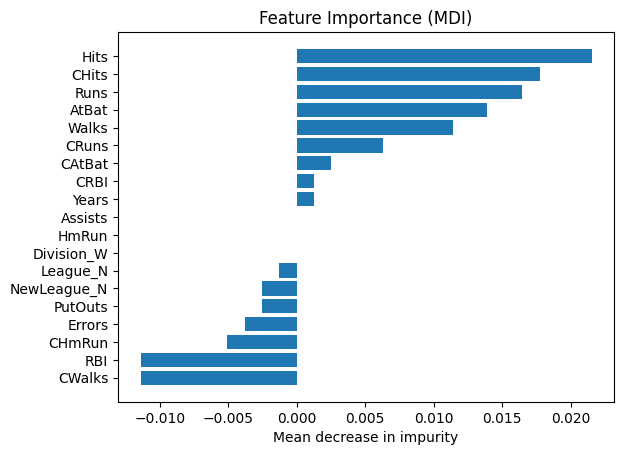

In [28]:
# sort features according to importance
sorted_idx = np.argsort(tree_importances)
pos = np.arange(sorted_idx.shape[0])

# plot feature importances
plt.barh(pos, tree_importances[sorted_idx], align="center")

plt.yticks(pos, np.array(feature_names)[sorted_idx])
plt.title("Feature Importance (MDI)")
plt.xlabel("Mean decrease in impurity");